## Project

1. Region and Domain: Brazil, sports and athletics
2. Research Question: How does the average travel distance for each team in the Brazilian 1st division
correlate with their final point tally (excl. punishments)?
3. Links:
    - [championship data](https://www.kaggle.com/datasets/adaoduque/campeonato-brasileiro-de-futebol/data?select=campeonato-brasileiro-full.csv)
    - [city distance data](https://data.mendeley.com/datasets/vj8bwtwynb/1)
4. Image (as follows)
5. Discussion (after the image)

Planning the plot: we have three possible dimensions  
- Final points % by year (int) -> x axis  
- Average distance travelled by year (float) -> y axis  
- Year (int) -> slider/button/whatever
  
Other variables we can study are:  
- Team (irrelevant in this case) -> maybe dot color?
- Final position in the championship (irrelevant in this case)  

Plan: scatter plot with these three dimensions

### Data preparation

In [1]:
# first taking a look at the dataframes
# football data
import pandas as pd
import numpy as np

fut_df = pd.read_csv('campeonato-brasileiro-full.csv', index_col=0)
fut_df.head()

,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado
ID,,,,,,,,,,,,,,,
1,1,29/03/2003,16:00,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ
2,1,29/03/2003,16:00,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS
3,1,30/03/2003,16:00,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR
4,1,30/03/2003,16:00,Goias,Paysandu,NaN,NaN,NaN,NaN,-,Serra Dourada,2,2,GO,PA
5,1,30/03/2003,16:00,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,Beira Rio,1,1,RS,SP


In [2]:
# so we don't have any data regarding points, but we have an indication of who the winner was
# in this case, from this data we need to extract:
# - a full list of teams participating in all years and their respective locations
# - for every year, the championship table based on who won/drew the games

In [3]:
# transforming the date data into datetime
fut_df['data'] = fut_df['data'].apply(pd.to_datetime, dayfirst=True)

In [4]:
# to correct the championship editions to the dates -> special case of the 2020 pandemic
def correct_edition(date):
    if date >= pd.Timestamp('2020-01-01') and date <= pd.Timestamp('2021-02-25'):
        return 2020
    elif date > pd.Timestamp('2021-03-01') and date <= pd.Timestamp('2021-12-31'):
        return 2021
    else:
        return date.year
fut_df['edition'] = fut_df['data'].apply(correct_edition)
fut_df

,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado,edition
ID,,,,,,,,,,,,,,,,
1,1,2003-03-29,16:00,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ,2003
2,1,2003-03-29,16:00,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS,2003
3,1,2003-03-30,16:00,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR,2003
4,1,2003-03-30,16:00,Goias,Paysandu,NaN,NaN,NaN,NaN,-,Serra Dourada,2,2,GO,PA,2003
5,1,2003-03-30,16:00,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,Beira Rio,1,1,RS,SP,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8783,38,2024-12-08,16:04,Cuiaba,Vasco,4-3-3,4-3-2-1,B. Franco,F. Loureiro,Vasco,Arena Pantanal,1,2,MT,RJ,2024
8784,38,2024-12-08,16:04,Palmeiras,Fluminense,4-2-3-1,4-2-3-1,A. Moreira Ferreira,L. Venker de Menezes,Fluminense,Allianz Parque,0,1,SP,RJ,2024
8776,38,2024-12-08,16:05,Fortaleza,Internacional,4-2-3-1,4-1-2-1-2,J. Vojvoda,R. Machado Marques,Fortaleza,Arena Castelão,3,0,CE,RS,2024


In [5]:
# wanted: a new dataframe, with year and team as a multi-index and the final point tally as the 'Points' column
# using the groupby method to generate this for home and away games and sum the final points

point_df = []
for group, frame in fut_df.groupby([fut_df['edition'], fut_df['mandante']])['vencedor']:
    point_tally = {}
    point_tally['year'] = group[0]
    point_tally['team'] = group[1]
    point_tally['points'] = 3*len(frame[frame == group[1]]) + 1*len(frame[frame == '-'])
    point_df.append(point_tally)
for group, frame in fut_df.groupby([fut_df['edition'], fut_df['visitante']])['vencedor']:
    point_tally = {}
    point_tally['year'] = group[0]
    point_tally['team'] = group[1]
    point_tally['points'] = 3*len(frame[frame == group[1]]) + 1*len(frame[frame == '-'])
    point_df.append(point_tally)
point_df = pd.DataFrame(point_df)
point_df = point_df.groupby(['year', 'team']).agg('sum')
point_df

points
year team                
2003 Athletico-PR      61
     Atletico-MG       72
     Bahia             46
     Corinthians       57
     Coritiba          73
...                   ...
2024 Juventude         45
     Palmeiras         73
     Sao Paulo         59
     Vasco             50
     Vitoria           47

[450 rows x 1 columns]

In [6]:
# adding point percentage column
# the formula for point percentage is the amount of points acquired divided by the possible points in the total games
# so we compute 100 times the points obtained in a given year divided by 3 times the total amount of games
# important to notice that in the early 2000's there was a different amount of teams in the championship

point_df['point %'] = 100*point_df['points']/(3*point_df.groupby(level=0).apply(lambda x : 2*len(x)-2))
point_df.head()

points    point %
year team                           
2003 Athletico-PR      61  44.202899
     Atletico-MG       72  52.173913
     Bahia             46  33.333333
     Corinthians       57  41.304348
     Coritiba          73  52.898551

In [7]:
# extracting and sorting all team names
team_list = fut_df['mandante'].unique()
team_list.sort()

# creating a truth table for the teams' locations
team_locs = ['Belo Horizonte', 'Natal', 'Curitiba', 'Goiânia',
             'Belo Horizonte', 'Florianópolis', 'Salvador', 'Barueri',
             'Rio de Janeiro', 'Bragança Paulista', 'Brasília',
             'Maceió', 'Fortaleza', 'Chapecó','São Paulo',
             'Curitiba', 'Criciúma', 'Belo Horizonte', 'Cuiabá',
             'Florianópolis', 'Rio de Janeiro', 'Rio de Janeiro', 'Fortaleza',
             'Goiânia', 'Porto Alegre', 'Presidente Prudente', 'Campinas',
             'Porto Alegre', 'Ipatinga', 'Joinville', 'Caxias do Sul',
             'Recife', 'São Paulo', 'Curitiba', 'Belém', 'Campinas',
             'São Paulo', 'Recife', 'Santo André', 'Santos', 'São Caetano do Sul',
             'São Paulo', 'Recife', 'Rio de Janeiro', 'Salvador']

team_list = pd.Series(dict(zip(team_list, team_locs)), name='team_list')
team_list

America-MG              Belo Horizonte
America-RN                       Natal
Athletico-PR                  Curitiba
Atletico-GO                    Goiânia
Atletico-MG             Belo Horizonte
Avai                     Florianópolis
Bahia                         Salvador
Barueri                        Barueri
Botafogo-RJ             Rio de Janeiro
Bragantino           Bragança Paulista
Brasiliense                   Brasília
CSA                             Maceió
Ceara                        Fortaleza
Chapecoense                    Chapecó
Corinthians                  São Paulo
Coritiba                      Curitiba
Criciuma                      Criciúma
Cruzeiro                Belo Horizonte
Cuiaba                          Cuiabá
Figueirense              Florianópolis
Flamengo                Rio de Janeiro
Fluminense              Rio de Janeiro
Fortaleza                    Fortaleza
Goias                          Goiânia
Gremio                    Porto Alegre
Gremio Prudente    Presid

In [8]:
team_list.index

colors = [('#35f900', '#000000'), ('#ed4033', '#d8d6d5'), ('#000000', '#b40d01'),
          ('#ed4033', '#191919'), ('#d8d6d5', '#191919'), ('#ffffff', "#66acfdb3"),
          ('#66adfd', '#ed4033'), ('#fced00', '#04017b'), ('#d8d6d5', '#2c2c2c'),
          ('#ffffff', '#dda6a6'), ('#fbf802', '#00b200'), ('#ffffff', '#04017b'),
          ('#ffffff', '#000000'), ('#ffffff', '#00b200'), ('#000000', '#000000'),
          ('#007f00', '#d8d6d5'), ('#fbf802', '#000000'), ('#04017b', '#ffffff'),
          ('#00b200', '#fbf802'), ('#007f00', '#000000'), ('#fa0600', '#000000'),
          ('#007f00', '#b40d01'), ('#ff0000', '#0000ff'), ('#35f900', '#d8d6d5'),
          ('#0076fa', '#000000'), ('#04017b', '#fced00'), ('#007f00', '#35f900'),
          ('#fa0600', '#fa0600'), ('#fa0600', '#007f00'), ('#191919', '#dda6a6'),
          ('#ffffff', '#80fc7e'), ('#ed4033', '#b40d01'), ('#007f00', '#007f00'),
          ('#b40d01', '#04017b'), ('#66adfd', '#ffffff'), ('#2c2c2c', '#2c2c2c'),
          ('#b40d01', '#007f00'), ('#ff0000', '#2c2c2c'), ('#0000ff', '#00b200'),
          ('#ffffff', '#e7b402'), ('#d8d6d5', '#fbf802'), ('#ff0000', '#d8d6d5'),
          ('#ff0000', '#e7b402'), ('#d8d6d5', '#d8d6d5'), ('#b40d01', '#2c2c2c')]

team_colors = pd.Series(dict(zip(list(team_list.index), colors)), name='team_colors')
team_colors

America-MG           (#35f900, #000000)
America-RN           (#ed4033, #d8d6d5)
Athletico-PR         (#000000, #b40d01)
Atletico-GO          (#ed4033, #191919)
Atletico-MG          (#d8d6d5, #191919)
Avai               (#ffffff, #66acfdb3)
Bahia                (#66adfd, #ed4033)
Barueri              (#fced00, #04017b)
Botafogo-RJ          (#d8d6d5, #2c2c2c)
Bragantino           (#ffffff, #dda6a6)
Brasiliense          (#fbf802, #00b200)
CSA                  (#ffffff, #04017b)
Ceara                (#ffffff, #000000)
Chapecoense          (#ffffff, #00b200)
Corinthians          (#000000, #000000)
Coritiba             (#007f00, #d8d6d5)
Criciuma             (#fbf802, #000000)
Cruzeiro             (#04017b, #ffffff)
Cuiaba               (#00b200, #fbf802)
Figueirense          (#007f00, #000000)
Flamengo             (#fa0600, #000000)
Fluminense           (#007f00, #b40d01)
Fortaleza            (#ff0000, #0000ff)
Goias                (#35f900, #d8d6d5)
Gremio               (#0076fa, #000000)


In [9]:
# now merging the team location to the team data
point_df = pd.merge(point_df, team_list.to_frame('location'), how='left', left_on='team', right_index=True)
point_df = pd.merge(point_df, team_colors.to_frame('colors'), how='left', left_on='team', right_index=True)
point_df

points    point %        location              colors
year team                                                               
2003 Athletico-PR      61  44.202899        Curitiba  (#000000, #b40d01)
     Atletico-MG       72  52.173913  Belo Horizonte  (#d8d6d5, #191919)
     Bahia             46  33.333333        Salvador  (#66adfd, #ed4033)
     Corinthians       57  41.304348       São Paulo  (#000000, #000000)
     Coritiba          73  52.898551        Curitiba  (#007f00, #d8d6d5)
...                   ...        ...             ...                 ...
2024 Juventude         45  39.473684   Caxias do Sul  (#ffffff, #80fc7e)
     Palmeiras         73  64.035088       São Paulo  (#007f00, #007f00)
     Sao Paulo         59  51.754386       São Paulo  (#ff0000, #d8d6d5)
     Vasco             50  43.859649  Rio de Janeiro  (#d8d6d5, #d8d6d5)
     Vitoria           47  41.228070        Salvador  (#b40d01, #2c2c2c)

[450 rows x 4 columns]

In [10]:
# moving over to the city data
city_df = pd.read_csv('mun_dist.csv')
city_df.head()

,nome_municipio1,cod_municipio1,nome_municipio2,cod_municipio2,distanciaGeo,distanciaCos,distanciaHsin,distanciaMeeus,distanciaSvince
0,Abadia de Goiás,5200050,Abadia de Goiás,5200050,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,Abadia dos Dourados,3100104,Abadia de Goiás,5200050,2.894718e+05,2.901556e+05,2.901556e+05,2.894700e+05,2.901556e+05
2,Abadiânia,5200100,Abadia de Goiás,5200050,1.000608e+05,1.002723e+05,1.002723e+05,1.000602e+05,1.002723e+05
3,Abaeté,3100203,Abadia de Goiás,5200050,4.996450e+05,5.003470e+05,5.003470e+05,4.996426e+05,5.003470e+05
4,Abaetetuba,1500107,Abadia de Goiás,5200050,1.664198e+06,1.674874e+06,1.674874e+06,1.664183e+06,1.674874e+06


In [11]:
# filtering only the cities appearing in our series
city_df = city_df[(city_df['nome_municipio1'].isin(team_list) &
                   city_df['nome_municipio2'].isin(team_list))]
city_df.head()

,nome_municipio1,cod_municipio1,nome_municipio2,cod_municipio2,distanciaGeo,distanciaCos,distanciaHsin,distanciaMeeus,distanciaSvince
3108618,Barueri,3505708,Barueri,3505708,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3108640,Belém,1501402,Barueri,3505708,2.445800e+06,2.460775e+06,2.460775e+06,2.445783e+06,2.460775e+06
3108641,Belém,2501906,Barueri,3505708,2.217920e+06,2.227057e+06,2.227057e+06,2.217903e+06,2.227057e+06
3108642,Belém,2700805,Barueri,3505708,1.897400e+06,1.904595e+06,1.904595e+06,1.897386e+06,1.904595e+06
3108652,Belo Horizonte,3106200,Barueri,3505708,5.017716e+05,5.033796e+05,5.033796e+05,5.017693e+05,5.033796e+05


In [12]:
# dropping corner cases: different cities with the same name
# Belém 2501906, Belém 2700805 and Santo André 2513851
city_df = city_df[~((city_df['cod_municipio1'] == 2501906) |
                    (city_df['cod_municipio1'] == 2700805) |
                    (city_df['cod_municipio1'] == 2513851))]

city_df = city_df[~((city_df['cod_municipio2'] == 2501906) |
                    (city_df['cod_municipio2'] == 2700805) |
                    (city_df['cod_municipio2'] == 2513851))]

len(city_df)

729

In [13]:
# retaining only the important columns
# here I select the distance measurement to be the 'distanciaGeo' column, as it considers the earth geoid
city_df = city_df[['nome_municipio1', 'nome_municipio2', 'distanciaGeo']]
city_df.head()

,nome_municipio1,nome_municipio2,distanciaGeo
3108618,Barueri,Barueri,0.000000e+00
3108640,Belém,Barueri,2.445800e+06
3108652,Belo Horizonte,Barueri,5.017716e+05
3108804,Bragança Paulista,Barueri,7.029286e+04
3108815,Brasília,Barueri,8.623545e+05


In [14]:
# now we need to calculate the total and average travelling distance for each team in each given year
# formula for total traveled distance: sum(2*distance from home city to every other city in the competition)
def calc_dist(team_frame, point_frame, year, team, dist_frame):
    home = team_frame['location'].iloc[0]
    away = list(point_frame.loc[year]['location'].drop(team))
    distances = []
    for item in away:
        dist = dist_frame[(dist_frame['nome_municipio1'] == home) & 
                          (dist_frame['nome_municipio2'] == item)].iloc[0].at['distanciaGeo']
        distances.append(dist)
    avg_dist = np.mean(distances)
    return {'year': year, 'team': team, 'dist': avg_dist}

avg_dist_df = []
for group, frame in point_df.groupby(level=(0,1)):
    avg_dist_df.append(calc_dist(frame, point_df, group[0], group[1], city_df))

avg_dist_df = pd.DataFrame(avg_dist_df).set_index(['year', 'team'])
avg_dist_df

dist
year team                      
2003 Athletico-PR  7.712585e+05
     Atletico-MG   8.261734e+05
     Bahia         1.491918e+06
     Corinthians   6.701868e+05
     Coritiba      7.712585e+05
...                         ...
2024 Juventude     1.118931e+06
     Palmeiras     7.006474e+05
     Sao Paulo     7.006474e+05
     Vasco         7.408585e+05
     Vitoria       1.439011e+06

[450 rows x 1 columns]

In [15]:
# converting the average distances to km
avg_dist_df['dist'] = avg_dist_df['dist']/1000
avg_dist_df.head()

dist
year team                     
2003 Athletico-PR   771.258544
     Atletico-MG    826.173359
     Bahia         1491.917902
     Corinthians    670.186794
     Coritiba       771.258544

In [16]:
# testing different teams to see the averages
avg_dist_df.loc[(slice(None), 'Ceara'),:]

,,dist
year,team,
2010,Ceara,2283.659855
2011,Ceara,2323.895627
2018,Ceara,2170.838731
2019,Ceara,2130.372870
2020,Ceara,2077.101394
2021,Ceara,2152.965996
2022,Ceara,2242.439727


In [17]:
# merging the two dfs to aggregate all data that will be used in plotting
toplot_df = pd.merge(point_df, avg_dist_df, how='inner', left_index=True, right_index=True)
toplot_df

points    point %        location              colors  \
year team                                                                  
2003 Athletico-PR      61  44.202899        Curitiba  (#000000, #b40d01)   
     Atletico-MG       72  52.173913  Belo Horizonte  (#d8d6d5, #191919)   
     Bahia             46  33.333333        Salvador  (#66adfd, #ed4033)   
     Corinthians       57  41.304348       São Paulo  (#000000, #000000)   
     Coritiba          73  52.898551        Curitiba  (#007f00, #d8d6d5)   
...                   ...        ...             ...                 ...   
2024 Juventude         45  39.473684   Caxias do Sul  (#ffffff, #80fc7e)   
     Palmeiras         73  64.035088       São Paulo  (#007f00, #007f00)   
     Sao Paulo         59  51.754386       São Paulo  (#ff0000, #d8d6d5)   
     Vasco             50  43.859649  Rio de Janeiro  (#d8d6d5, #d8d6d5)   
     Vitoria           47  41.228070        Salvador  (#b40d01, #2c2c2c)   

                          dist  
year team                       
2003 Athletico-PR   771.258544  
     Atletico-MG    826.173359  
     Bahia         1491.917902  
     Corinthians    670.186794  
     Coritiba       771.258544  
...                        ...  
2024 Juventude     1118.930561  
     Palmeiras      700.647447  
     Sao Paulo      700.647447  
     Vasco          740.858526  
     Vitoria       1439.010609  

[450 rows x 5 columns]

### Now for the plotting

In [18]:
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from scipy import stats

%matplotlib widget

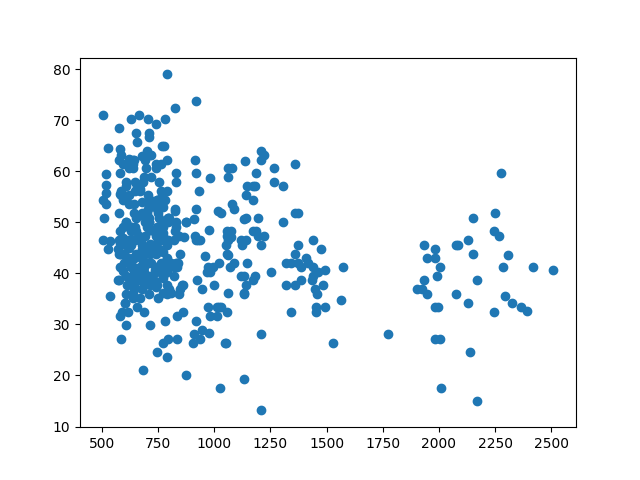

In [19]:
plt.scatter(x=toplot_df['dist'], y=toplot_df['point %']);

In [20]:
list(toplot_df.index.get_level_values(0).unique())

[2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024]

0

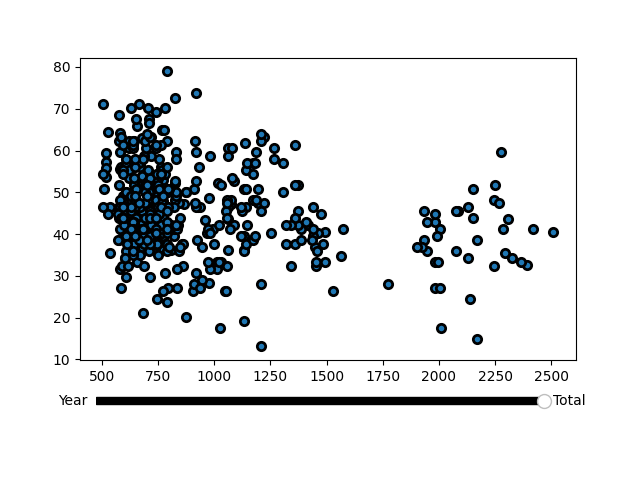

In [21]:
# steps: 1 - year discrete slider; 2 - team colors; 3 - make it nice
# step 1
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25)
pts = plt.scatter(x=toplot_df['dist'], y=toplot_df['point %'], edgecolors='k', linewidths=2)
ax_year = fig.add_axes([0.15, 0.15, 0.70, 0.03])

allowed_years = list(toplot_df.index.get_level_values(0).unique())
allowed_years.append('Total')
indices = np.arange(0,len(allowed_years),1)

# creating the slider
s_year = widgets.Slider(
    ax_year, 'Year', indices[0],
    indices[-1], valinit=indices[-1],
    valstep=indices, initcolor='none',
    color='black'
)

# setting the text display
# text_display = ax.text(2400, 15, allowed_years[-1], size=14, ha='center', va='center')
s_year.valtext.set_text(allowed_years[-1])

def update(val):
    new_index = s_year.val
    new_year = allowed_years[new_index]
    if new_year == 'Total':
        filtered_x = toplot_df['dist']
        filtered_y = toplot_df['point %']
        pts.set_offsets(np.column_stack((filtered_x, filtered_y)))
    else:
        filtered_x = toplot_df['dist'].loc[new_year]
        filtered_y = toplot_df['point %'].loc[new_year]
        pts.set_offsets(np.column_stack((filtered_x, filtered_y)))
    # text_display.set_text(new_year)
    s_year.valtext.set_text(new_year)
    fig.canvas.draw_idle()

s_year.on_changed(update)

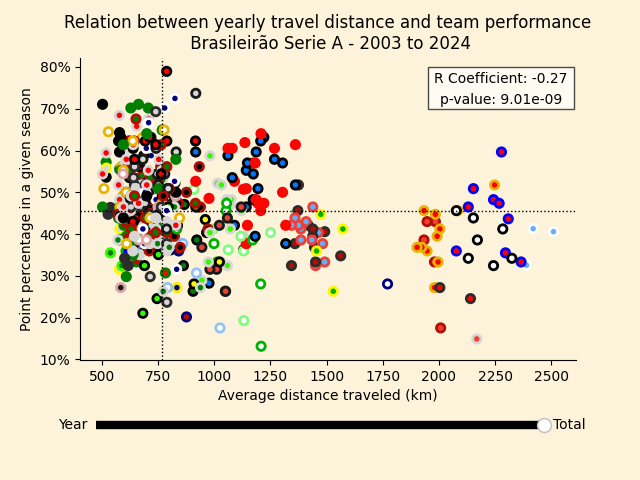

In [22]:
# step 2
# creating the team colors
def update_colors(dataframe, year=None):
    if year is None or year == 'Total':
        inner_c = [item[0] for item in list(dataframe['colors'])]
        edge_c = [item[1] for item in list(dataframe['colors'])]
    else:
        inner_c = [item[0] for item in list(dataframe['colors'].loc[year])]
        edge_c = [item[1] for item in list(dataframe['colors'].loc[year])]
    return inner_c, edge_c

init_c, init_edge = update_colors(toplot_df)

# calculating Pearson-R correlation initial values
rval_init, pval_init = stats.pearsonr(toplot_df['point %'], toplot_df['dist'])

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25)
pts = plt.scatter(x=toplot_df['dist'], y=toplot_df['point %'], c=init_c, edgecolors=init_edge, linewidths=2)
ax_year = fig.add_axes([0.15, 0.1, 0.70, 0.03])

xline = ax.axhline(np.median(toplot_df['point %']), linewidth=1, linestyle=':',color='k', label='median')
yline = ax.axvline(np.median(toplot_df['dist']), linewidth=1, linestyle=':', color='k')

rect = patches.Rectangle((1950,70),650,10, linewidth=1, edgecolor='k', facecolor='w', alpha=0.7)
ax.add_patch(rect)
txt_rval = ax.text(2275, 77, 'R Coefficient: '+str(round(rval_init,2)), va='center', ha='center')
txt_pval = ax.text(2275, 72, 'p-value: '+f"{pval_init:.2e}", va='center', ha='center')

ax.set_facecolor("#FCF3DA")
fig.set_facecolor('#FCF3DA')

allowed_years = list(toplot_df.index.get_level_values(0).unique())
allowed_years.append('Total')
indices = np.arange(0,len(allowed_years),1)

ax.set_title('Relation between yearly travel distance and team performance\n Brasileirão Serie A - {} to {}'.format(
    allowed_years[0], allowed_years[-2]))
ax.set_xlabel('Average distance traveled (km)')
ax.set_ylabel('Point percentage in a given season')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.spines[['right', 'top']].set_visible(False)
plt.grid()

# creating the slider
s_year = widgets.Slider(
    ax_year, 'Year', indices[0],
    indices[-1], valinit=indices[-1],
    valstep=indices, initcolor='none',
    color='black'
)

# setting the text display
s_year.valtext.set_text(allowed_years[-1])

def update(val):
    new_index = s_year.val
    new_year = allowed_years[new_index]
    new_inner_c, new_edge_c = update_colors(toplot_df, new_year)
    if new_year == 'Total':
        filtered_x = toplot_df['dist']
        filtered_y = toplot_df['point %']
        pts.set_offsets(np.column_stack((filtered_x, filtered_y)))
        pts.set_facecolor(new_inner_c)
        pts.set_edgecolor(new_edge_c)
        xline.set_ydata([np.median(filtered_y),np.median(filtered_y)])
        yline.set_xdata([np.median(filtered_x),np.median(filtered_x)])
        rval, pval = stats.pearsonr(filtered_y, filtered_x)
        txt_rval.set_text('R Coefficient: '+str(round(rval,2)))
        txt_pval.set_text('p-value: '+f"{pval:.2e}")
    else:
        filtered_x = toplot_df['dist'].loc[new_year]
        filtered_y = toplot_df['point %'].loc[new_year]
        pts.set_offsets(np.column_stack((filtered_x, filtered_y)))
        pts.set_facecolor(new_inner_c)
        pts.set_edgecolor(new_edge_c)
        xline.set_ydata([np.median(filtered_y),np.median(filtered_y)])
        yline.set_xdata([np.median(filtered_x),np.median(filtered_x)])
        rval, pval = stats.pearsonr(filtered_y, filtered_x)
        txt_rval.set_text('R Coefficient: '+str(round(rval,2)))
        txt_pval.set_text('p-value: '+f"{pval:.2e}")
    s_year.valtext.set_text(new_year)
    fig.canvas.draw_idle()

s_year.on_changed(update);